# Group Project: Bank marketing

## Imports:

In [5]:
import matplotlib.pyplot as plt
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
import plotnine as p9
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## TODO


<br>

---

## Data Exploration

### Load Data

In [6]:
bank = pd.read_csv("BankMarketing.csv")

### Data Summary

In [3]:
y_yes_ratio = bank.y.value_counts().yes / bank.y.value_counts().no
print(bank.y.value_counts())
print(y_yes_ratio)

no     36548
yes     4640
Name: y, dtype: int64
0.126956331399803


### Exploring variables that have values `unknown`

In [4]:
unknown_no = bank.apply(pd.value_counts).dropna(axis=1, subset=["unknown"]).loc["unknown"]
display(unknown_no)

job           330.0
marital        80.0
education    1731.0
default      8597.0
housing       990.0
loan          990.0
Name: unknown, dtype: float64

Helper-function: `generate_ratio_df(df, column)` :  
* Takes df and a column name as input
* calculates the ratio of `yes` to `no` values of column `y` in the distinct values of the specified column
* returns a df that only contains the unique values of `column`, the `yes` and `no` counts as well as the ratio `yes/no`

In [7]:
def generate_ratio_df(df, column):
    result = df.loc[:,[column, "y", "age"]].groupby([column, "y"]).agg("count")
    result = result.unstack().reset_index()
    result.columns = result.columns.get_level_values(0)
    result.columns = [column, "y_no_count", "y_yes_count"]
    result["y_ratio"] = result["y_yes_count"] / (result["y_yes_count"] + result["y_no_count"])
    return result

In [8]:
default_df = generate_ratio_df(bank, "default")
display(default_df)

,default,y_no_count,y_yes_count,y_ratio
0,no,28391.0,4197.0,0.12879
1,unknown,8154.0,443.0,0.05153
2,yes,3.0,NaN,NaN


#### Attribute `default`

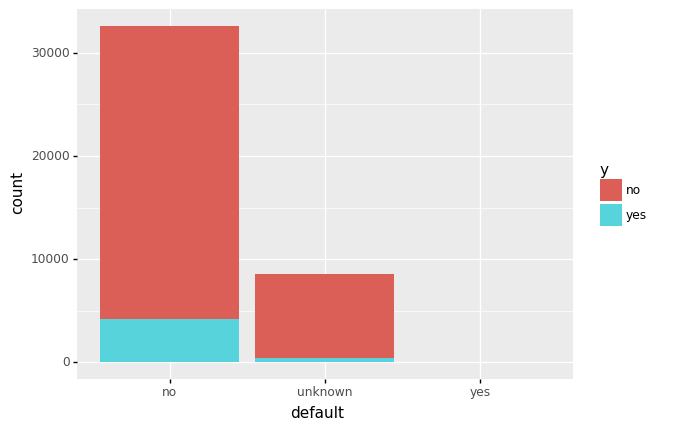

<ggplot: (-9223371840610571136)>

In [6]:
(p9.ggplot(data=bank)
        + p9.geom_bar(mapping=p9.aes(x="default", fill="y"))
)

Get default ratio and absolute numbers:

In [7]:
default_df = generate_ratio_df(bank, "default")
display(default_df)

,default,y_no_count,y_yes_count,y_ratio
0,no,28391.0,4197.0,0.147829
1,unknown,8154.0,443.0,0.054329
2,yes,3.0,NaN,NaN


What does this tell us?
* we can treat the category `unknown` as a distinct 3rd value apart from `yes` and `no`
    * it is a stronger indicator for the target value than the category `no`, whereas it seems that first of all almost no calls have been made to people with a faulty default. But for the 3 phone calls that have been made, none were successful in terms of the target variable (but that may also be because of the small sample at hand of `yes`)

<br>

#### Attribute `education`

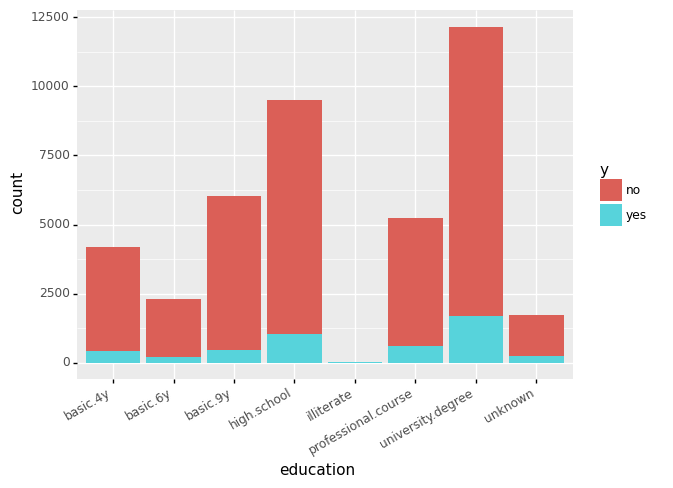

<ggplot: (-9223371840610575344)>

In [8]:
(p9.ggplot(data=bank)
        + p9.geom_bar(mapping=p9.aes(x="education", fill="y"))
        + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)

Get default ratio and absolute numbers:

In [9]:
education_df = generate_ratio_df(bank, "education")

In [10]:
display(education_df)

,education,y_no_count,y_yes_count,y_ratio
0,basic.4y,3748,428,0.114194
1,basic.6y,2104,188,0.089354
2,basic.9y,5572,473,0.084889
3,high.school,8484,1031,0.121523
4,illiterate,14,4,0.285714
5,professional.course,4648,595,0.128012
6,university.degree,10498,1670,0.159078
7,unknown,1480,251,0.169595


What does this tell us?
* We can't tell if `unknown` can be treated as a valid category
    * But it has the highest ratio after `illiterate` (which is most likely to be because of the small sample of 18 cases only)
* Idea: A/B testing with and without the entries denoted as `unknown`
* Other idea: assign `university.degree` to unknown, as it is closest in terms of the `y_ratio`

<br>

### Attributes `housing` & `loan`

In [11]:
#touples = []
#for i in range(2,4):
#    for j in ["job", "marital", "education", "default", "housing", "loan"]:
#        touples.append(("housing, loan", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown")])))
    
unknown_comb = pd.DataFrame([
    ("housing, loan", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown")])),
    ("housing, yes", len(bank.loc[(bank["housing"] == "yes")])),
    ("loan, yes", len(bank.loc[(bank["loan"] == "yes")])),
    ("housing, no", len(bank.loc[(bank["housing"] == "no")])),
    ("loan, no", len(bank.loc[(bank["loan"] == "no")])),
    ("housing, loan, yes", len(bank.loc[(bank["housing"] == "yes") & (bank["loan"] == "yes")])),
    ("housing, loan, no", len(bank.loc[(bank["housing"] == "no") & (bank["loan"] == "no")])),
    ("housing, loan, pdays=999", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["pdays"] == 999)])),
    ("housing, loan, default", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["default"] == "unknown")])),
    ("housing, loan, education", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["education"] == "unknown")])),
    ("housing, loan, marital", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["marital"] == "unknown")])),
    ("housing, loan, job", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["job"] == "unknown")])),
    ("housing, loan, default, education", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["default"] == "unknown") & (bank["education"] == "unknown")])),
    ("housing, loan, default, marital", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["default"] == "unknown") & (bank["marital"] == "unknown")])),
    ("housing, loan, default, job", len(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown") & (bank["default"] == "unknown") & (bank["job"] == "unknown")])),
    ("job, marital", len(bank.loc[(bank["job"] == "unknown") & (bank["marital"] == "unknown")])),
    ("job, education", len(bank.loc[(bank["job"] == "unknown") & (bank["education"] == "unknown")])),
    ("job, education, default", len(bank.loc[(bank["job"] == "unknown") & (bank["education"] == "unknown") & (bank["default"] == "unknown")]))   
], columns=["attributes", "unknown-count"])

display(bank.loc[(bank["housing"] == "unknown") & (bank["loan"] == "unknown")])

display(unknown_comb.sort_values(by="unknown-count", ascending=False))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
29,55,unknown,married,university.degree,unknown,unknown,unknown,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
81,51,blue-collar,married,basic.4y,unknown,unknown,unknown,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
261,27,blue-collar,single,basic.6y,no,unknown,unknown,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
385,59,management,married,basic.4y,unknown,unknown,unknown,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
401,48,services,married,high.school,unknown,unknown,unknown,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40990,31,admin.,single,university.degree,no,unknown,unknown,cellular,oct,tue,...,1,3,1,success,-1.1,94.601,-49.5,1.008,4963.6,yes
41014,31,technician,single,professional.course,no,unknown,unknown,cellular,oct,thu,...,2,999,0,nonexistent,-1.1,94.601,-49.5,1.025,4963.6,yes
41015,34,admin.,divorced,university.degree,no,unknown,unknown,cellular,oct,thu,...,2,999,1,failure,-1.1,94.601,-49.5,1.025,4963.6,no
41029,46,management,married,university.degree,no,unknown,unknown,cellular,oct,mon,...,2,12,2,failure,-1.1,94.601,-49.5,1.032,4963.6,no


,attributes,unknown-count
4,"loan, no",33950
1,"housing, yes",21576
3,"housing, no",18622
6,"housing, loan, no",16065
2,"loan, yes",6248
5,"housing, loan, yes",3691
0,"housing, loan",990
7,"housing, loan, pdays=999",956
8,"housing, loan, default",227
16,"job, education",131


We see, that all `unknown` values of `housing` and `loan` are in the same rows.
* also a few of the `default` values are `unknown` in these rows
* The `pdays` is almost always `999` which means, that in these cases there as not been a contact between these customers and the bank before
* These results may indicate, that there will be cases where the bank encounters a new customer that it has never contacted. Based on the `unknown` values, these rows could easily be eliminated. But this will consequently also mean, that our model is not suited to deal with customers that miss some information and have never been contacted.
    * idea: we could develop 2 separate models: one that deals with "new" customers and one that deals with "known" customers. The question is, if this will improve prediction quality or not.

Checking `pdays`:

<AxesSubplot:xlabel='pdays', ylabel='Count'>

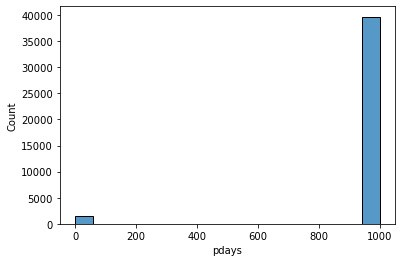

In [12]:
sns.histplot(bank.pdays)

* the `pdays` being `999` does not tell us anything?

In [13]:
pdays_df = generate_ratio_df(bank, "pdays")
temp_df = pd.DataFrame(
    [
        ["0-27",
         pdays_df.iloc[0:25,1].sum(),
         pdays_df.iloc[0:25,2].sum(),
         pdays_df.iloc[0:25,2].sum() / pdays_df.iloc[0:25,1].sum()]
    ],
    columns=["pdays",
             "y_no_count",
             "y_yes_count",
             "y_ratio"])
# reindex to have a proper concat result:
temp_df.index.values[0] = len(pdays_df)
#pdays_df = pd.concat([pdays_df.iloc[[26]], temp_df])
pdays_df = pd.concat([pdays_df, temp_df])
display(pdays_df)

,pdays,y_no_count,y_yes_count,y_ratio
0,0,5.0,10.0,2.000000
1,1,18.0,8.0,0.444444
2,2,24.0,37.0,1.541667
3,3,141.0,298.0,2.113475
4,4,55.0,63.0,1.145455
5,5,17.0,29.0,1.705882
6,6,123.0,289.0,2.349593
7,7,20.0,40.0,2.000000
8,8,6.0,12.0,2.000000
9,9,29.0,35.0,1.206897


While the `pdays` being 999 does not tell us a lot, it being some other value than 999 does: it has a great impact on the target variable!
* idea: set `pdays` to be __categorical__ with categories: `999` or `not 999`.

---

<br>

### Univariate Analysis of Attributes A (Bank client data)

#### Age

In [14]:
print(bank.age.nunique())
print(bank.age.unique())

78
[56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]


<AxesSubplot:xlabel='age', ylabel='Count'>

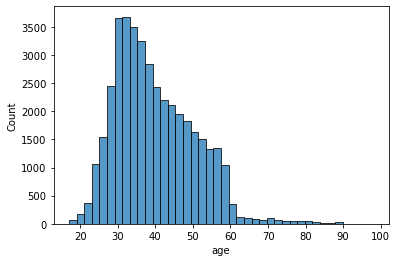

In [15]:
sns.histplot(x=bank.age, bins=40)

<AxesSubplot:xlabel='age'>

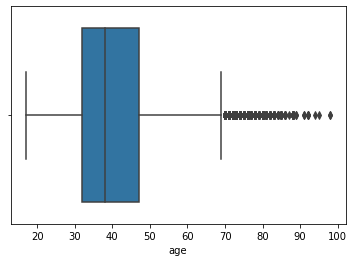

In [16]:
sns.boxplot(x=bank.age)

In [17]:
print(len(bank.loc[bank["age"]<25]))
print(len(bank.loc[bank["age"]>60]))

1068
910


* Outliers are at age >90
* sparse quantity from age 60 onwards

Binning `Age`

In [18]:
age_bins = [0, 21, 31, 41, 51, 61, 100]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '>60']
bank["age_bins_6"] = pd.cut(bank["age"], bins=age_bins, labels=age_labels)
bank["age_bins_6"] = pd.Categorical(values=bank["age_bins_6"], categories=age_labels, ordered=True)

Other bins:

In [19]:
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['0-24', '25-34', '35-44', '45-54', '55-64', '>64']
bank["age_bins_6_2"] = pd.cut(bank["age"], bins=age_bins, labels=age_labels)
bank["age_bins_6_2"] = pd.Categorical(values=bank["age_bins_6_2"], categories=age_labels, ordered=True)

In [20]:
age_bins = [0, 26, 31, 36, 41, 46, 51, 56, 61, 66, 100]
age_labels = ['0-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '>65']
bank["age_bins_6_3"] = pd.cut(bank["age"], bins=age_bins, labels=age_labels)
bank["age_bins_6_3"] = pd.Categorical(values=bank["age_bins_6_3"], categories=age_labels, ordered=True)

In [21]:
bank["age_bins_5"] = pd.qcut(bank["age"], q=5)
bank["age_bins_10"] = pd.qcut(bank["age"], q=10)
bank["age_bins_20"] = pd.qcut(bank["age"], q=20)

Age x Y

In [22]:
age_df = generate_ratio_df(bank, "age_bins_6")
print(age_df)
age_df_2 = generate_ratio_df(bank, "age_bins_6_2")
print(age_df_2)
age_df_5 = generate_ratio_df(bank, "age_bins_6_3")
print(age_df_5)
age_df_3 = generate_ratio_df(bank, "age_bins_20")
print(age_df_3)
age_df_4 = generate_ratio_df(bank, "age_bins_10")
print(age_df_4)
age_df_6 = generate_ratio_df(bank, "age_bins_5")
print(age_df_6)

  age_bins_6  y_no_count  y_yes_count   y_ratio
0       0-20         156           86  0.551282
1      21-30        7830         1258  0.160664
2      31-40       14226         1490  0.104738
3      41-50        8920          796  0.089238
4      51-60        4961          628  0.126587
5        >60         455          382  0.839560
  age_bins_6_2  y_no_count  y_yes_count   y_ratio
0         0-24        1317          349  0.264996
1        25-34       13107         1740  0.132753
2        35-44       11751         1093  0.093013
3        45-54        7532          717  0.095194
4        55-64        2512          451  0.179538
5          >64         329          290  0.881459
  age_bins_6_3  y_no_count  y_yes_count   y_ratio
0         0-25        1893          471  0.248811
1        26-30        6093          873  0.143279
2        31-35        8064          899  0.111483
3        36-40        6162          591  0.095910
4        41-45        4914          427  0.086895
5        46-50

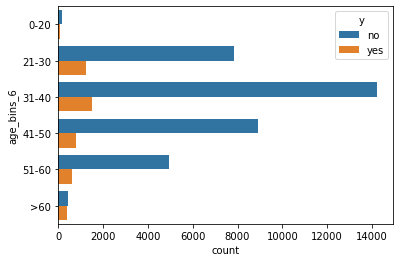

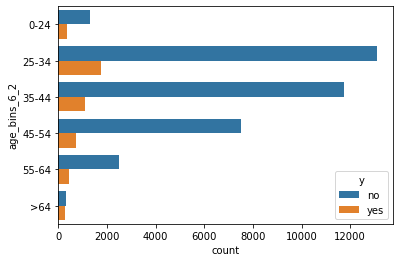

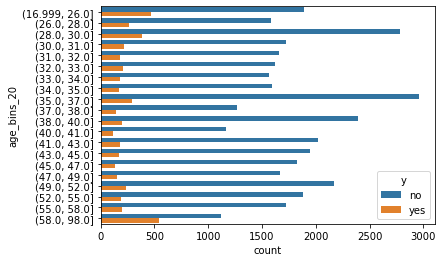

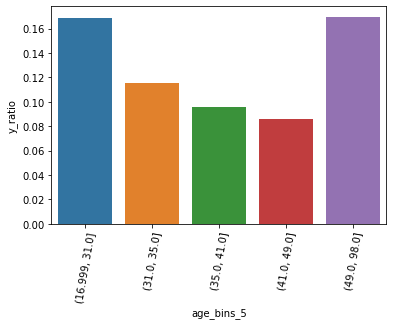

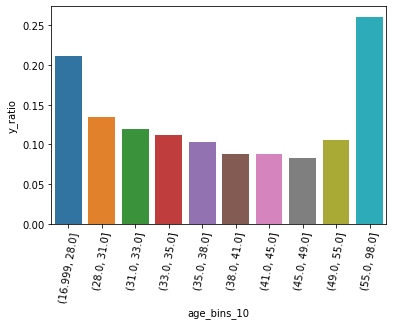

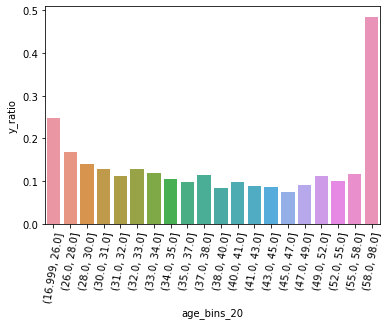

In [23]:
# 6 bins 0-19...
sns.countplot(y="age_bins_6", hue="y", data=bank)
plt.show()
# 6 bins 0-24 ...
sns.countplot(y="age_bins_6_2", hue="y", data=bank)
plt.show()
# 20 bins, countplot
sns.countplot(y="age_bins_20", hue="y", data=bank)
plt.show()
# 5 bins
sns.barplot(data=age_df_6, x="age_bins_5", y="y_ratio")
plt.xticks(rotation=80)
plt.show()
# 10 bins
sns.barplot(data=age_df_4, x="age_bins_10", y="y_ratio")
plt.xticks(rotation=80)
plt.show()
# 20 bins
sns.barplot(data=age_df_3, x="age_bins_20", y="y_ratio")
plt.xticks(rotation=80)
plt.show()

#### Conclusion:
* observations from age 0-24 and from 61-100 have the highest yes/no ratio, but also the lowest observations in comparison to the age range they represent (around 1000 observations each)
* the closer an age is to age 45 from the edges, the lower the yes/no ratio
* 2 approaches:
    * bins with even counts -> caputring outlier notions without overweighting them. But danger of "cannibalizing" the yes/no ratio of the ages close to the outliers (~25-30 and  ~50-60)
    * bins with even age ranges + outlier bins <25 and >60 -> danger of overweighting outliers
* in both cases it makes sense to chose a bin count of 5-10 -> rather 5 than 10
* LabelEncode the classes

<br>

#### Job 

In [24]:
print(bank.job.nunique())
print(bank.job.unique())

12
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']


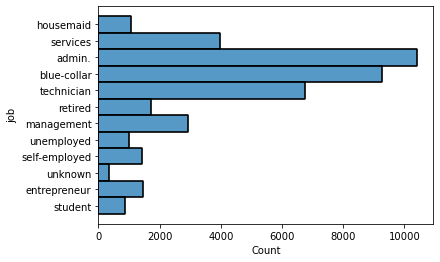

In [25]:
p = sns.histplot(y=bank.job)
plt.show()

<AxesSubplot:xlabel='count', ylabel='job'>

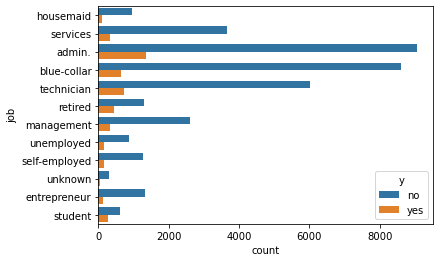

In [26]:
sns.countplot(y="job", hue="y", data=bank)

In [27]:
job_df = generate_ratio_df(bank, "job")
print(job_df)

              job  y_no_count  y_yes_count   y_ratio
0          admin.        9070         1352  0.149063
1     blue-collar        8616          638  0.074048
2    entrepreneur        1332          124  0.093093
3       housemaid         954          106  0.111111
4      management        2596          328  0.126348
5         retired        1286          434  0.337481
6   self-employed        1272          149  0.117138
7        services        3646          323  0.088590
8         student         600          275  0.458333
9      technician        6013          730  0.121404
10     unemployed         870          144  0.165517
11        unknown         293           37  0.126280


#### Thoughts:
* low-paid job:
    * blue-collar
    * housemaid
    * student
    * services
    * unemployed
    * unknown (?)
* well-paid jobs:
    * admin.
    * entrepreneur
    * management
    * retired
    * self-employed
    * technician
    
Observations
* unemployed has a high y-ratio
    * maybe because they are looking for risk-averse deposits?
* student has a high y-ratio (low count)
    * maybe becaue they do not have fixed financials yet and are open for new things or maybe do not possess the knowledge?
* manager has a moderately high y-ratio (medium count)
    * maybe because a manager already has his/her finances sorted out and is generally interested in investments with a higher reward?
* administration has a high y-ratio (high count)
    * maybe generally wealthy, but risk-averse individuals?
* retired has a high y-ratio (high count)
    * not looking for anything risky while maybe being wealthy
* entrepreneur has a low y-ratio (medium count)
    * usually invested in his company, no money for long-term deposits, living a fast life

<br>

#### Marital

In [28]:
print(bank.marital.nunique())
print(bank.marital.unique())

4
['married' 'single' 'divorced' 'unknown']


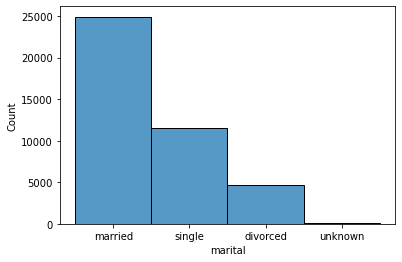

In [29]:
p = sns.histplot(x=bank.marital)
plt.show()

<AxesSubplot:xlabel='count', ylabel='marital'>

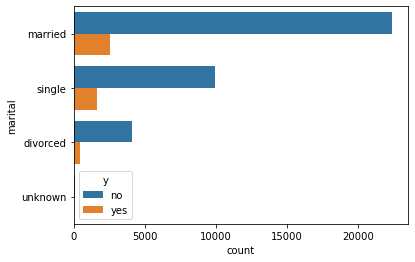

In [30]:
sns.countplot(y="marital", hue="y", data=bank)

__NOTE__: it may make sense, to use Label Encoding on marital, as there is a clear order: `single`, `married`, `divorced`

Background: If married, it would usually be stated. So most likely 'unknown' is single.  
Alternative approach: just assign most likely case which is 'married'

<AxesSubplot:xlabel='age', ylabel='Count'>

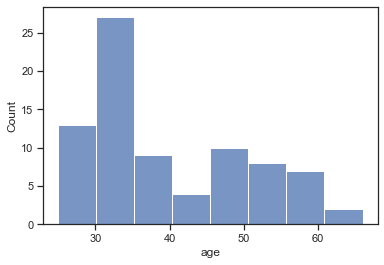

In [78]:
sns.histplot(bank.loc[bank["marital"] == "unknown"].age)


<AxesSubplot:xlabel='age', ylabel='Count'>

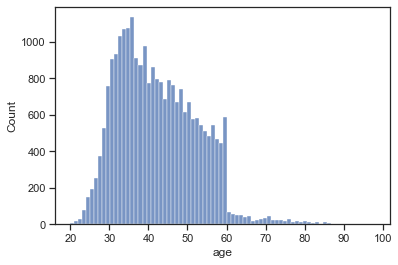

In [79]:
sns.histplot(bank.loc[bank["marital"] == "married"].age)

-> assign married (highest prob)

<br>

#### Education

In [31]:
print(bank.education.nunique())
print(bank.education.unique())

8
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']


In [32]:
bank["education_cat"] = pd.Categorical(values=bank["education"], categories=["unknown", "illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"], ordered=True)

#confirm that no row values have been swapped:
(bank["education"] == bank["education_cat"]).all()

True

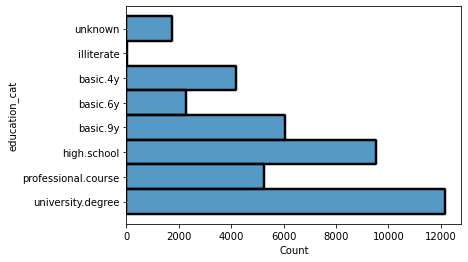

In [33]:
p = sns.histplot(y=bank.education_cat)
plt.show()

<AxesSubplot:xlabel='count', ylabel='education_cat'>

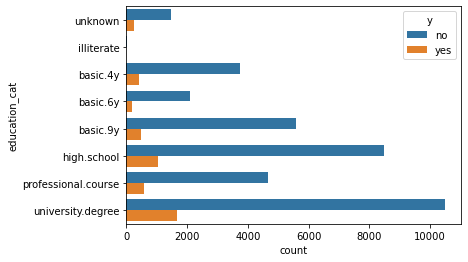

In [34]:
sns.countplot(y="education_cat", hue="y", data=bank)

__NOTE__: it may make sense, to use Label Encoding on education, as there is a clear order: (, `unknown`), `illiterate`, `basic.4y`, `basic.6y`, `basic.9y`, `high.school`, `professional.course`, `university.degree`  
Also it might be considered, that `professional.course` and `high.school` may be merged into one category as they seem to be "on the same level" and their yes-no-ratio is also fairly close (0.12...). But it might be a good idea to put professional.course before high.school, as it can also be taken by people that did not finish the complete 9 years of basic education ?

Unclear is, whether the professional.course represents the __Professional Programmes__ (https://en.wikipedia.org/wiki/Education_in_Portugal#Professional_Programmes) and therefore is equal to the __General Programmes__ which seems to be general high school, or if it is representing the apprenticeship, which is covering topics from the basic education as well as the secondary education (?).

In German, the whole thing is more obvious: the `professional.course` means the __Cursos Profissionais__, which is also a __Secondary Education__ after 9 years of basic (primary) education. But as this allows to better enter the job market and it most probably also covers topics that are job-relevant and usually seen in Universities, it can be argued that `professional.course` is to be rated higher that the `high.school`, at least when it comes to our target variable.

__Basic education__  
In Portugal, Basic Education consists of nine years of schooling divided into __three sequential cycles of education of four, two and three years__.

Children aged six by 15 September must be enrolled in their first school year in that calendar year. In addition, children who reach the age of six between 16 September and 31 December may be authorized to attend the first stage of education, provided a request is submitted by their parents or guardians to the school nearest to their residence (or place of work) during the annual enrollment period. State-run schools are free of charge; private school tuition is refunded by the State in part or fully, when state-run schools in the area are filled to capacity. The first cycle of basic mandatory education covers years 1st-4th, the second cycle years 5th-6th and the third cycle years 7th-9th. The curriculum contains only general education until the 9th year at which point vocational subjects are introduced.

At the end of each cycle, students take national evaluation exams for the subjects of Portuguese Language and Mathematics. Schools do not give (or sell) any books or materials; financial assistance is available for poorer families. The school books are chosen at school's level every four years.

1st Cycle State-run schools are owned by the municipalities; all other State-run schools are owned by the State.

(https://en.wikipedia.org/wiki/Education_in_Portugal#1%C2%BA_Ciclo_-_1st_Cycle)

<br>

#### Default

In [35]:
print(bank.default.nunique())
print(bank.default.unique())

3
['no' 'unknown' 'yes']


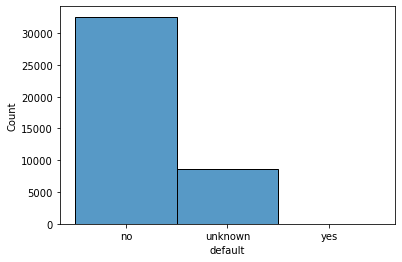

In [36]:
p = sns.histplot(x=bank.default)
plt.show()

<AxesSubplot:xlabel='count', ylabel='default'>

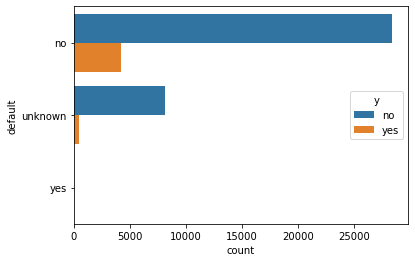

In [37]:
sns.countplot(y="default", hue="y", data=bank)

<br>

#### Housing

In [38]:
print(bank.housing.nunique())
print(bank.housing.unique())

3
['no' 'yes' 'unknown']


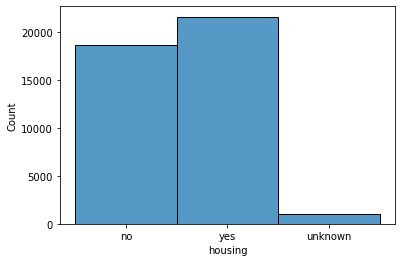

In [39]:
p = sns.histplot(x=bank.housing)
plt.show()

<AxesSubplot:xlabel='count', ylabel='housing'>

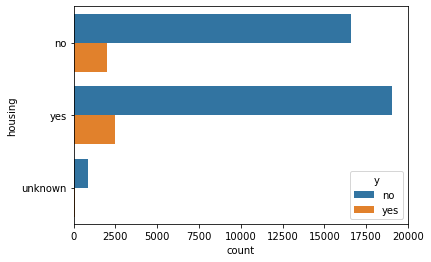

In [40]:
sns.countplot(y="housing", hue="y", data=bank)

In [82]:
housing_df = generate_ratio_df(bank, "housing")
print(housing_df)

   housing  y_no_count  y_yes_count   y_ratio
0       no       16596         2026  0.122078
1  unknown         883          107  0.121178
2      yes       19069         2507  0.131470


-> try out if unknown + no as one cat is different from keeping the categories

<br>

#### Loan

In [41]:
print(bank.loan.nunique())
print(bank.loan.unique())

3
['no' 'yes' 'unknown']


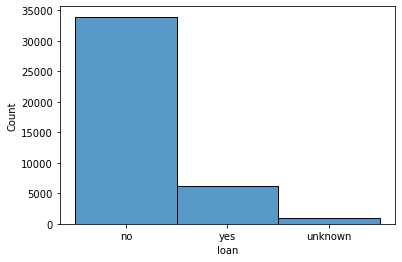

In [42]:
p = sns.histplot(x=bank.loan)
plt.show()

<AxesSubplot:xlabel='count', ylabel='loan'>

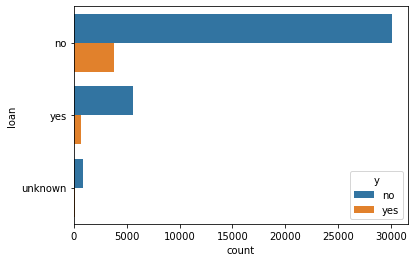

In [43]:
sns.countplot(y="loan", hue="y", data=bank)

In [83]:
loan_df = generate_ratio_df(bank, "loan")
print(loan_df)

      loan  y_no_count  y_yes_count   y_ratio
0       no       30100         3850  0.127907
1  unknown         883          107  0.121178
2      yes        5565          683  0.122731


---

<br>

### Multivariate analysis

For the following: rate-of-yes-graphs

#### Age x Marital x Housing

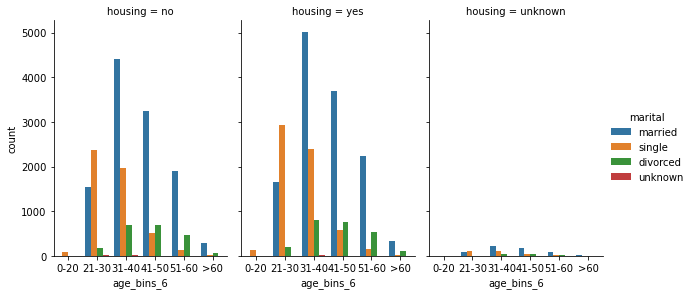

In [44]:
p = sns.catplot(x="age_bins_6", hue="marital", col="housing",
                data=bank, kind="count",
                height=4, aspect=.7)
#sns.histplot(x="age", hue="job", data=bank, bins=10)

#### Age x Loan

<AxesSubplot:xlabel='age_bins_5', ylabel='count'>

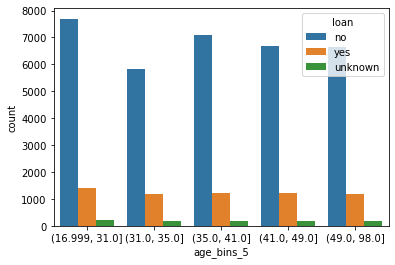

In [45]:
sns.countplot(x="age_bins_5", hue="loan", data=bank)

#### Age x Housing

<AxesSubplot:xlabel='age_bins_6', ylabel='count'>

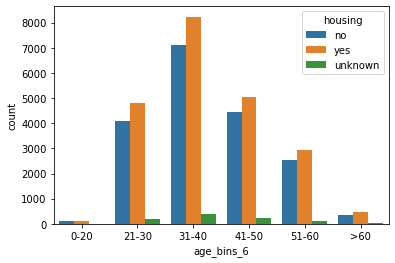

In [46]:
sns.countplot(x="age_bins_6", hue="housing", data=bank)

#### Job x Education

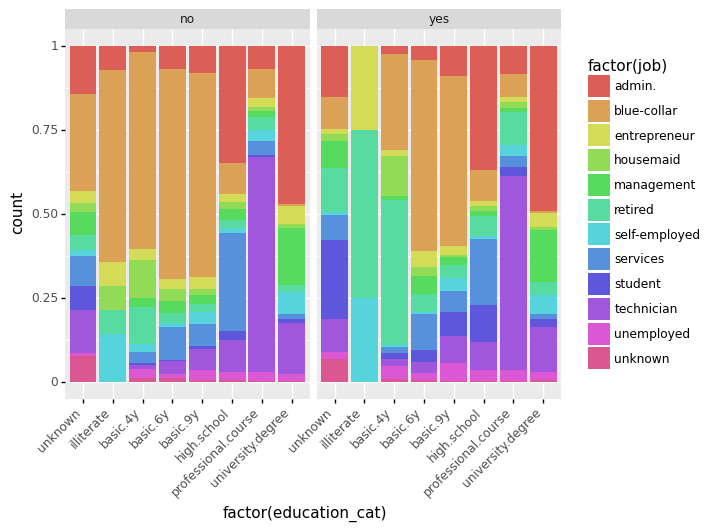

<ggplot: (-9223371840610128276)>

In [47]:
(p9.ggplot(data=bank)
    + p9.geom_bar(mapping=p9.aes(x='factor(education_cat)', fill='factor(job)'), position='fill')
    + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
    + p9.facet_wrap('y')
)

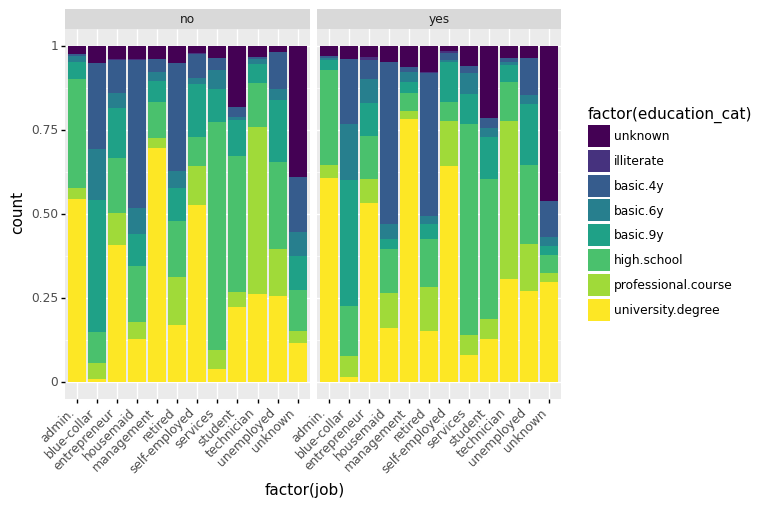

<ggplot: (-9223371840609790596)>

In [48]:
(p9.ggplot(data=bank)
    + p9.geom_bar(mapping=p9.aes(x='factor(job)', fill='factor(education_cat)'), position='fill')
    + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
    + p9.facet_wrap('y')
)

In [49]:
print(education_df)

             education  y_no_count  y_yes_count   y_ratio
0             basic.4y        3748          428  0.114194
1             basic.6y        2104          188  0.089354
2             basic.9y        5572          473  0.084889
3          high.school        8484         1031  0.121523
4           illiterate          14            4  0.285714
5  professional.course        4648          595  0.128012
6    university.degree       10498         1670  0.159078
7              unknown        1480          251  0.169595


In [50]:
print(job_df)

              job  y_no_count  y_yes_count   y_ratio
0          admin.        9070         1352  0.149063
1     blue-collar        8616          638  0.074048
2    entrepreneur        1332          124  0.093093
3       housemaid         954          106  0.111111
4      management        2596          328  0.126348
5         retired        1286          434  0.337481
6   self-employed        1272          149  0.117138
7        services        3646          323  0.088590
8         student         600          275  0.458333
9      technician        6013          730  0.121404
10     unemployed         870          144  0.165517
11        unknown         293           37  0.126280


In [51]:
bank.loc[bank["education"] == "illiterate"]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,euribor3m,nr.employed,y,age_bins_6,age_bins_6_2,age_bins_6_3,age_bins_5,age_bins_10,age_bins_20,education_cat
5393,45,blue-collar,married,illiterate,unknown,no,yes,telephone,may,fri,...,4.857,5191.0,no,41-50,35-44,41-45,"(41.0, 49.0]","(41.0, 45.0]","(43.0, 45.0]",illiterate
6928,45,blue-collar,married,illiterate,unknown,no,no,telephone,may,thu,...,4.860,5191.0,no,41-50,35-44,41-45,"(41.0, 49.0]","(41.0, 45.0]","(43.0, 45.0]",illiterate
12383,51,admin.,married,illiterate,unknown,no,no,cellular,jul,mon,...,4.960,5228.1,no,41-50,45-54,46-50,"(49.0, 98.0]","(49.0, 55.0]","(49.0, 52.0]",illiterate
14445,55,blue-collar,married,illiterate,no,yes,no,cellular,jul,tue,...,4.961,5228.1,no,51-60,45-54,51-55,"(49.0, 98.0]","(49.0, 55.0]","(52.0, 55.0]",illiterate
14486,55,blue-collar,married,illiterate,no,no,no,cellular,jul,tue,...,4.961,5228.1,no,51-60,45-54,51-55,"(49.0, 98.0]","(49.0, 55.0]","(52.0, 55.0]",illiterate
16269,60,housemaid,married,illiterate,unknown,yes,no,cellular,jul,tue,...,4.961,5228.1,no,51-60,55-64,56-60,"(49.0, 98.0]","(55.0, 98.0]","(58.0, 98.0]",illiterate
17739,54,blue-collar,married,illiterate,unknown,yes,yes,cellular,jul,tue,...,4.961,5228.1,no,51-60,45-54,51-55,"(49.0, 98.0]","(49.0, 55.0]","(52.0, 55.0]",illiterate
22402,45,blue-collar,married,illiterate,no,yes,no,cellular,aug,fri,...,4.964,5228.1,no,41-50,35-44,41-45,"(41.0, 49.0]","(41.0, 45.0]","(43.0, 45.0]",illiterate
22642,44,blue-collar,married,illiterate,no,no,no,cellular,aug,fri,...,4.964,5228.1,no,41-50,35-44,41-45,"(41.0, 49.0]","(41.0, 45.0]","(43.0, 45.0]",illiterate
26680,34,self-employed,married,illiterate,no,yes,no,cellular,nov,thu,...,4.076,5195.8,no,31-40,25-34,31-35,"(31.0, 35.0]","(33.0, 35.0]","(33.0, 34.0]",illiterate


We can clearly see, that there is a dependency of `education` to `job` :  
* `unknown` to `basic.9y` : are mostly working in _blue-collar_ jobs, so jobs that do not require a special education and are generally low-paid
* with a higher-value degree, the chances of working in _administration_, as a _technician_ or in _management_ are rising
* the chance of working as a _technician_ when you have a `professional.course` degree are extremely high  

What we see when comparing the `y` outcomes:
* in the lower education (`unknown`-`basic.9y`, customers that are NOT working as a _blue-collar_ have a higher chance of making a deposit
* in the higher education (`high.school`-`university.degree`), the job does not influence the outcome of `y` significantly. But it can be seen, that for _students_, the chances of making a deposit generally higher

Grouping:
* illiterate can either be dropped due to its small row count, or it should be included in another category
* the basic education levels are all very similar when it comes to y_ratio, row count and distribution of jobs -> could be seen as one category
    * basic.4y is a bit off in terms of y_ratio and jobs that have y=yes -> might be because are generally more self-employed people -> that effect could be captured by the job influence
* `high.school`, `professional.course` and `university.degree` all have two things in common: the low ratio of low-paid jobs and the insignificance of the jobs on the target variable
* `unknown` education is basically just a mixture of the other educations as we can see in the jobs associated with this class, BUT it seems that the student count is higher -> see ratio of positive `y` outcomes in comparison to negative `y` outcomes

Checking ratio of `student` job in `unknown` education and others:

In [52]:
print(bank.loc[(bank["education"] == "unknown") & (bank["job"] == "student")].count().mode()/bank.loc[bank["education"] == "unknown"].count().mode())
print(bank.loc[(bank["education"] == "university.degree") & (bank["job"] == "student")].count().mode()/bank.loc[bank["education"] == "university.degree"].count().mode())
print(bank.loc[(bank["education"] == "high.school") & (bank["job"] == "student")].count().mode()/bank.loc[bank["education"] == "high.school"].count().mode())

0    0.096476
dtype: float64
0    0.013971
dtype: float64
0    0.03752
dtype: float64


-> We can clearly see, that the high y_ratio of education == unknown is explained by the high ratio of students.  
We might therefore infer, that often for students, their education is not known.  
-> think about what that means for our grouping & for job + education

Seperating higher and lower education:

In [53]:
basic_education_count = 3748+2104+5572+14+428+188+473+4
basic_education_y_ratio = (428+188+473+4)/(3748+2104+5572+14)
higher_education_count = 8484+4648+10498+1031+595+1670
higher_education_y_ratio = (1031+595+1670)/(8484+4648+10498)
print("basic count: {}, ratio: {:02.4f}\nhigher count: {}, ratio: {:02.4f}".format(basic_education_count, basic_education_y_ratio, higher_education_count, higher_education_y_ratio))
#print("check if unknown is a mixture of the other data:\nratio unknown: {:02.4f}, ratio basic&higher: {:02.4f}".format(0.169595, (basic_education_count/(basic_education_count+higher_education_count)*higher_education_count(basic_education_count+higher_education_count))))

basic count: 12531, ratio: 0.0956
higher count: 26926, ratio: 0.1395


---

<br>

### Quantitative Variables

### Attribute `contact`

In [54]:
contact_df = generate_ratio_df(bank, "contact")

In [55]:
display(contact_df)

contact_age = bank.loc[:,["contact", "y", "age"]].groupby(["contact", "y"]).agg(np.mean)

,contact,y_no_count,y_yes_count,y_ratio
0,cellular,22291,3853,0.172850
1,telephone,14257,787,0.055201


In [56]:
contact_age

age
contact   y             
cellular  no   39.789422
          yes  41.004931
telephone no   40.101564
          yes  40.463787

<br>

### Attribute `month`

-> Campaign & duration

In [57]:
month_df = generate_ratio_df(bank, "month")

In [58]:
display(month_df)

,month,y_no_count,y_yes_count,y_ratio
0,apr,2093,539,0.257525
1,aug,5523,655,0.118595
2,dec,93,89,0.956989
3,jul,6525,649,0.099464
4,jun,4759,559,0.117462
5,mar,270,276,1.022222
6,may,12883,886,0.068773
7,nov,3685,416,0.112890
8,oct,403,315,0.781638
9,sep,314,256,0.815287


### Attribute `day_of_week`

In [59]:
day_of_week_df = generate_ratio_df(bank, "day_of_week")

In [60]:
display(day_of_week_df)

,day_of_week,y_no_count,y_yes_count,y_ratio
0,fri,6981,846,0.121186
1,mon,7667,847,0.110473
2,thu,7578,1045,0.137899
3,tue,7137,953,0.133529
4,wed,7185,949,0.132081


### Attribute `duration`

Remove impact of attribute in data  
Group

In [61]:
duration_df = generate_ratio_df(bank, "duration")

In [62]:
display(duration_df)

,duration,y_no_count,y_yes_count,y_ratio
0,0,4.0,NaN,NaN
1,1,3.0,NaN,NaN
2,2,1.0,NaN,NaN
3,3,3.0,NaN,NaN
4,4,12.0,NaN,NaN
...,...,...,...,...
1539,3631,NaN,1.0,NaN
1540,3643,NaN,1.0,NaN
1541,3785,1.0,NaN,NaN
1542,4199,NaN,1.0,NaN


### Attribute `poutcomes`

Remove impact of attribute in data  
Group

In [63]:
poutcome_df = generate_ratio_df(bank, "poutcome")

In [64]:
display(poutcome_df)

,poutcome,y_no_count,y_yes_count,y_ratio
0,failure,3647,605,0.165890
1,nonexistent,32422,3141,0.096879
2,success,479,894,1.866388


### Attribute `campaign`

In [65]:
campaign_df = bank.copy()
campaign_bins = [0, 2, 3, 4, 6, 100]
campaign_labels = ["1", "2", "3", "4-5", "6-99"]
campaign_df["campaign"] = pd.cut(campaign_df["campaign"], bins=campaign_bins, labels=campaign_labels)
display(campaign_df)
display(campaign_df.campaign.unique())
campaign_df = generate_ratio_df(campaign_df, "campaign")
display(campaign_df)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,euribor3m,nr.employed,y,age_bins_6,age_bins_6_2,age_bins_6_3,age_bins_5,age_bins_10,age_bins_20,education_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,4.857,5191.0,no,51-60,55-64,51-55,"(49.0, 98.0]","(55.0, 98.0]","(55.0, 58.0]",basic.4y
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,4.857,5191.0,no,51-60,55-64,56-60,"(49.0, 98.0]","(55.0, 98.0]","(55.0, 58.0]",high.school
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,4.857,5191.0,no,31-40,35-44,36-40,"(35.0, 41.0]","(35.0, 38.0]","(35.0, 37.0]",high.school
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,4.857,5191.0,no,31-40,35-44,36-40,"(35.0, 41.0]","(38.0, 41.0]","(38.0, 40.0]",basic.6y
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,4.857,5191.0,no,51-60,55-64,51-55,"(49.0, 98.0]","(55.0, 98.0]","(55.0, 58.0]",high.school
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1.028,4963.6,yes,>60,>64,>65,"(49.0, 98.0]","(55.0, 98.0]","(58.0, 98.0]",professional.course
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1.028,4963.6,no,41-50,45-54,41-45,"(41.0, 49.0]","(45.0, 49.0]","(45.0, 47.0]",professional.course
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,1.028,4963.6,no,51-60,55-64,51-55,"(49.0, 98.0]","(55.0, 98.0]","(55.0, 58.0]",university.degree
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1.028,4963.6,yes,41-50,35-44,41-45,"(41.0, 49.0]","(41.0, 45.0]","(43.0, 45.0]",professional.course


['1', '2', '3', '4-5', '6-99']
Categories (5, object): ['1' < '2' < '3' < '4-5' < '6-99']

,campaign,y_no_count,y_yes_count,y_ratio
0,1,24701,3511,0.142140
1,2,4767,574,0.120411
2,3,2402,249,0.103664
3,4-5,2383,195,0.081830
4,6-99,2295,111,0.048366


<br>

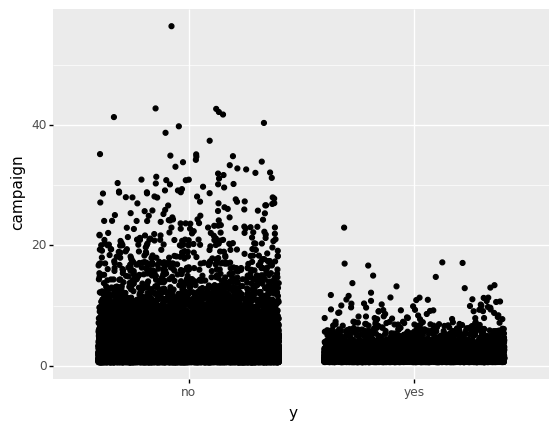

<ggplot: (-9223371840609390812)>

In [66]:
(p9.ggplot(data=bank)
        + p9.geom_point(mapping=p9.aes(x="y", y="campaign"), position="position_jitter")
)

#### Some boxplots...

<AxesSubplot:>

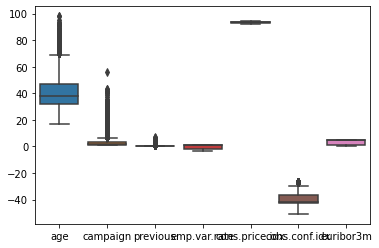

In [67]:
sns.boxplot(data=bank.loc[:,["age", "campaign", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m"]])

<AxesSubplot:>

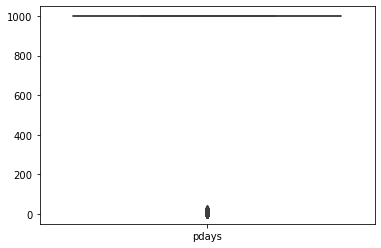

In [68]:
sns.boxplot(data=bank.loc[:,["pdays"]])

<AxesSubplot:>

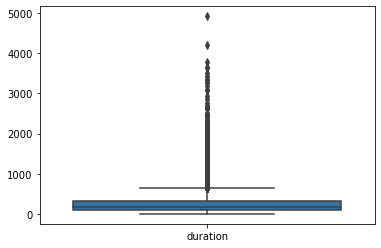

In [69]:
sns.boxplot(data=bank.loc[:,["duration"]])

<AxesSubplot:>

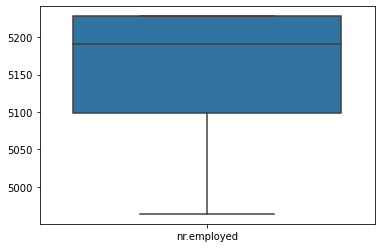

In [70]:
sns.boxplot(data=bank.loc[:,["nr.employed"]])

#### Pairplot

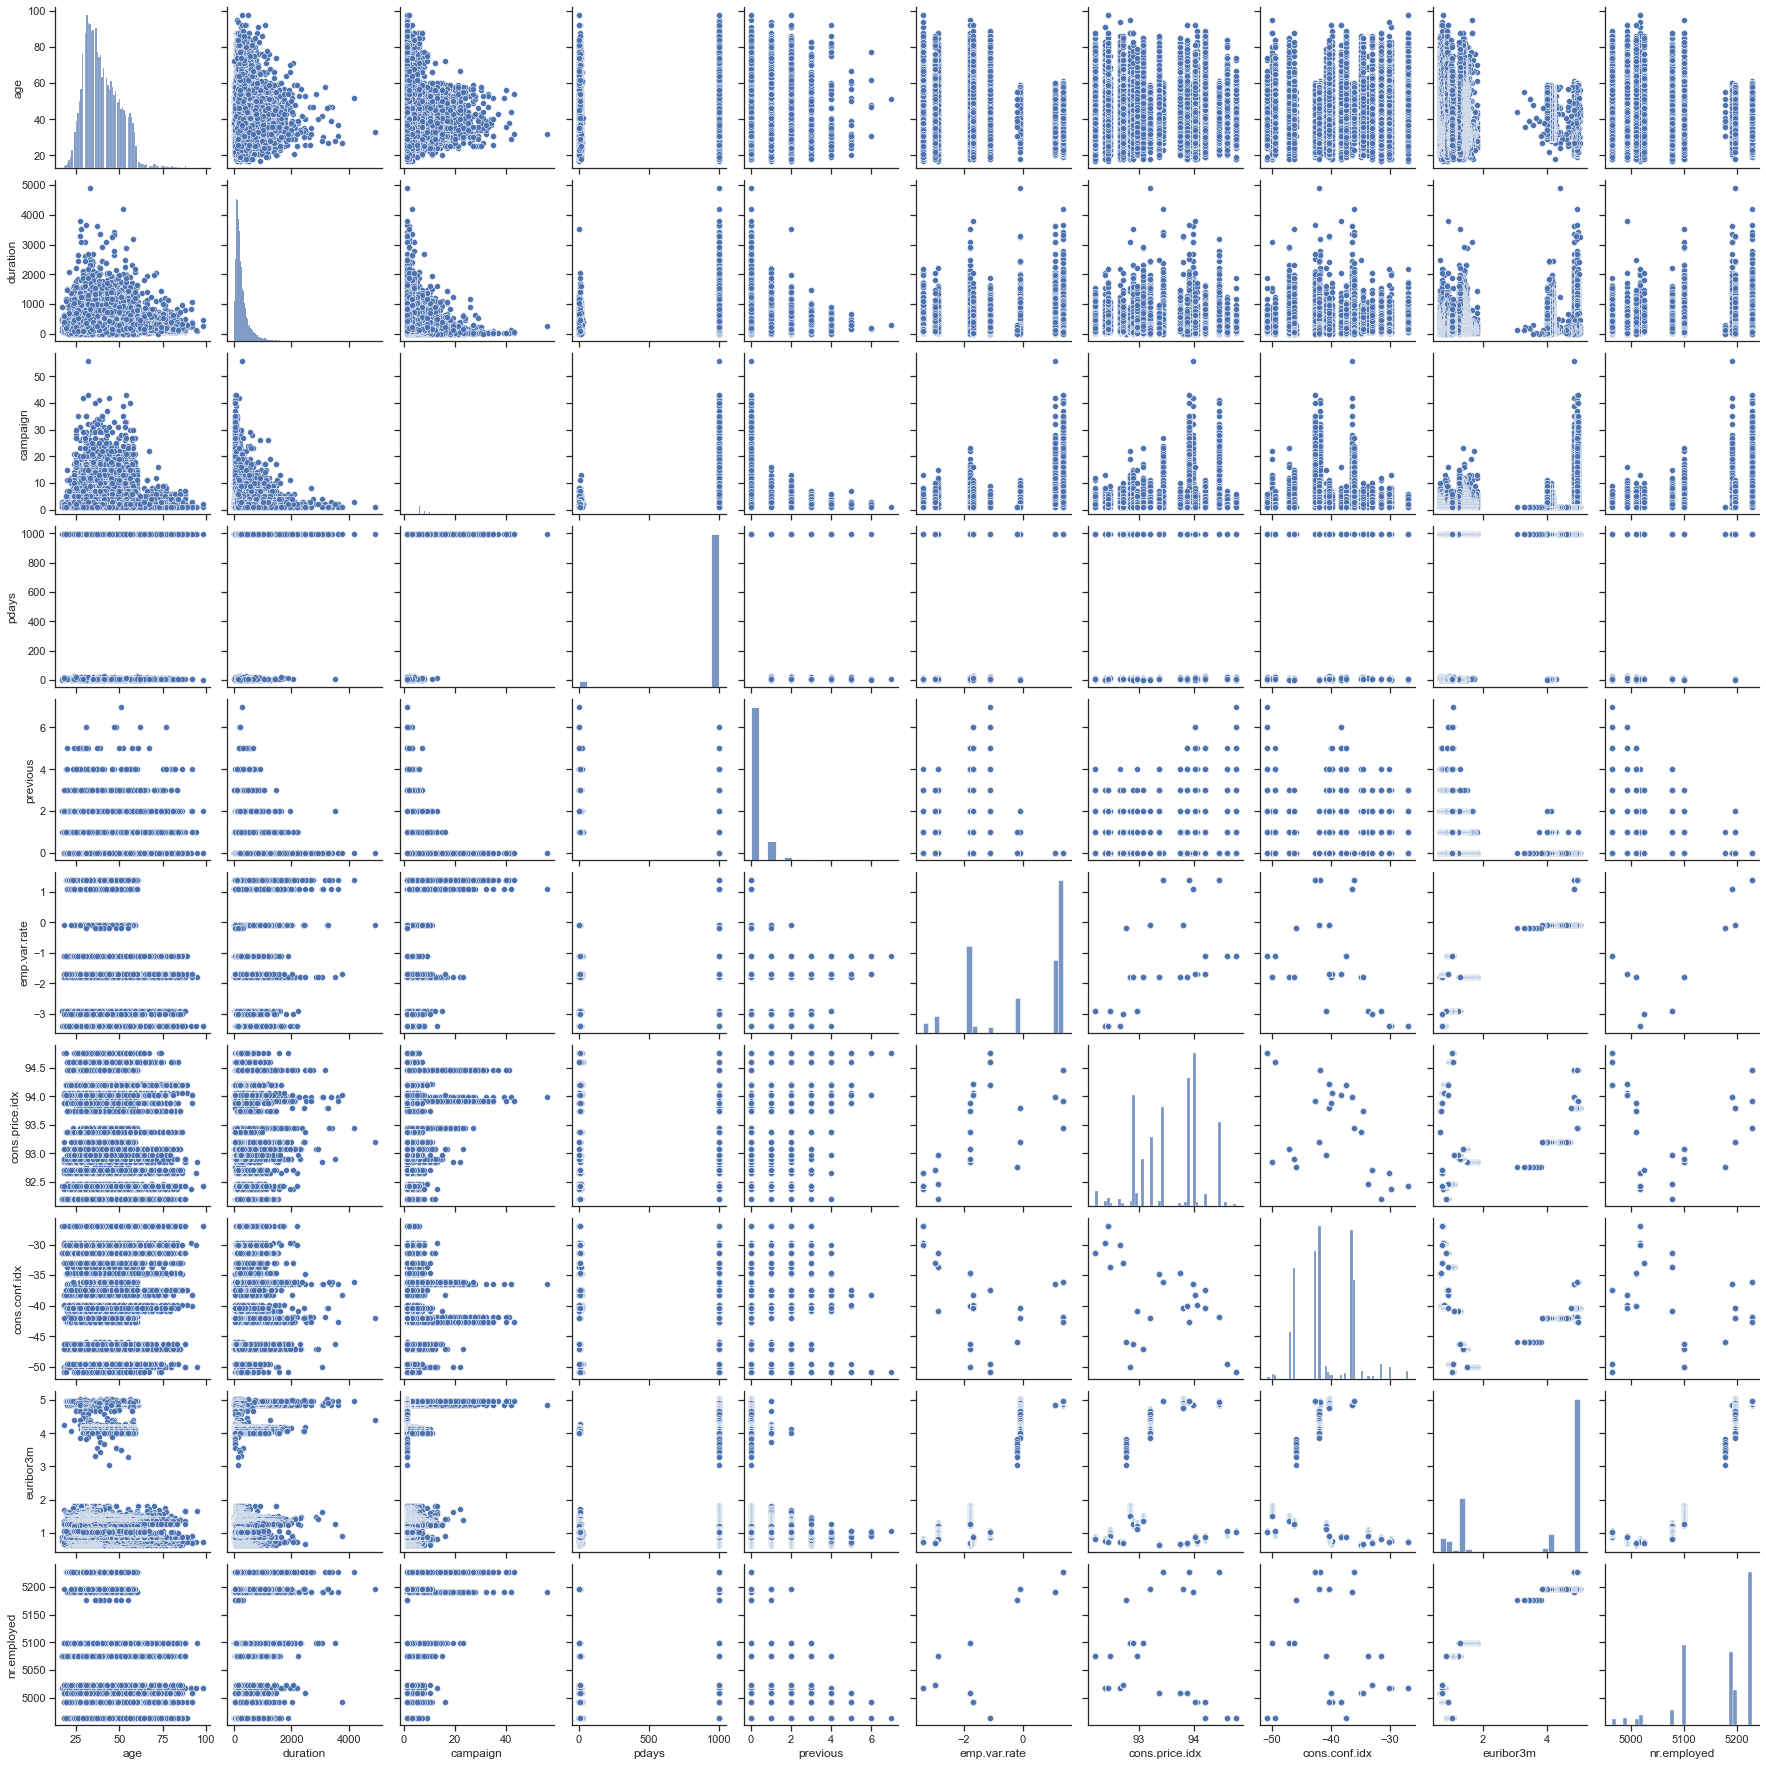

In [71]:
sns.set(style="ticks")
sns.pairplot(bank)

<br>

### Data Description

Goals:
1. Predict, if client will subscribe a term deposit
2. Decrease number of phone calls (efficiency)
3. increase total number of deposit subscriptions (effectiveness)

Measures:
* Minimize false positives (unnecessary calls)
* Maximize 

<br>

---

## Data Cleaning

<br>

---

## Data Wrangling

<br>

---

## Model Preparation

### Replacing & grouping Weekdays:

In [72]:
day_df = bank.copy()
day_df.loc[((day_df["day_of_week"] == "tue") | (day_df["day_of_week"] == "wed") | (day_df["day_of_week"] == "thu")), "day_of_week"] = "midweek"

In [73]:
display(day_df.day_of_week.unique())

array(['mon', 'midweek', 'fri'], dtype=object)

<br>

---

## Classification

In [74]:
list_ = [("abc_def", 1), ("abc_defg", 1), ("abc_defgt", 1), ("abcdef", 10), ("abcdef", 10), ("a_bcd", 1), ("a_bcd", 1)]


def sum_attribute_importance_dummy(list_):
    curr_prefix = ""
    curr_values = []
    result_list = []
    i = 0
    for name,no in list_:
        name_part = name.partition("_")[0]
        if  name_part == name:
            if curr_prefix != "":
                result_list.append((curr_prefix, np.sum(curr_values)))
            result_list.append((name_part, no))
            curr_prefix = ""
            curr_values = []
        else:
            if name_part == curr_prefix:
                curr_values.append(no)
            else:
                if curr_prefix == "":
                    curr_prefix = name_part
                    curr_values = [no]
                else:
                    result_list.append((curr_prefix, np.sum(curr_values)))
                    curr_prefix = name_part
                    curr_values = [no]
        i += 1
        if i == len(list_):
            result_list.append((curr_prefix, np.sum(curr_values)))
    return result_list

In [75]:
print(sum_attribute_importance_dummy(list_))

[('abc', 3), ('abcdef', 10), ('abcdef', 10), ('a', 2)]


In [84]:
previous_df = generate_ratio_df(bank, "previous")

In [85]:
print(previous_df)

   previous  y_no_count  y_yes_count   y_ratio
0         0     32422.0       3141.0  0.096879
1         1      3594.0        967.0  0.269060
2         2       404.0        350.0  0.866337
3         3        88.0        128.0  1.454545
4         4        32.0         38.0  1.187500
5         5         5.0         13.0  2.600000
6         6         2.0          3.0  1.500000
7         7         1.0          NaN       NaN


In [97]:
bank.previous.value_counts(dropna=False)

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

---

---

<br>

# SHAP MODEL

This Script is from data_final
it is upsampeld times: 1
Random-Forest-Results-Training: /n: {'mean_fit_time': array([13.17116921]), 'std_fit_time': array([0.13533313]), 'mean_score_time': array([0.27114475]), 'std_score_time': array([0.04623682]), 'param_max_depth': masked_array(data=[10],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[400],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 10, 'n_estimators': 400}], 'split0_test_score': array([0.85311077]), 'split1_test_score': array([0.8616085]), 'split2_test_score': array([0.85462822]), 'split3_test_score': array([0.84886191]), 'split4_test_score': array([0.85432473]), 'split5_test_score': array([0.85280728]), 'split6_test_score': array([0.84734446]), 'split7_test_score': array([0.85796662]), 'split8_test_score': array([0.86763813]), 'split9_test_score': array([0.8527626]), 'mean_test_score': array([0.85510532])

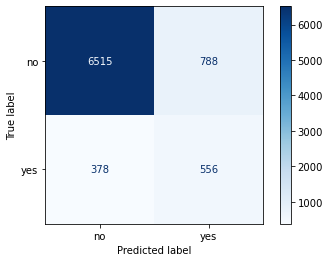

Classification Report 
               precision    recall  f1-score   support

          no       0.95      0.89      0.92      7303
         yes       0.41      0.60      0.49       934

    accuracy                           0.86      8237
   macro avg       0.68      0.74      0.70      8237
weighted avg       0.88      0.86      0.87      8237

0.48814749780509215
[[0.80088876 0.19911124]
 [0.65026419 0.34973581]
 [0.61395681 0.38604319]
 [0.73462188 0.26537812]
 [0.57627728 0.42372272]
 [0.7800075  0.2199925 ]]
[0 0 0 0 0 0]
[0.         0.         0.         ... 0.99753526 0.99780912 1.        ] [0.         0.00107066 0.00535332 ... 1.         1.         1.        ] [1.98149366 0.98149366 0.97631754 ... 0.1251124  0.12505647 0.09895675]
0.7996841226552932


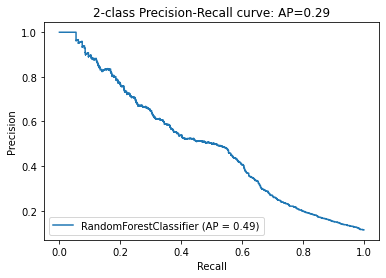

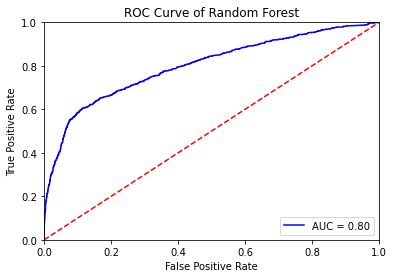

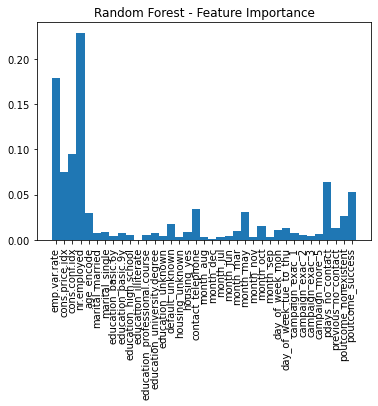

[('emp.var.rate', 0.17917764494560817), ('cons.price.idx', 0.07457321517843189), ('cons.conf.idx', 0.0950800163921786), ('nr.employed', 0.2286752671358936), ('age_encode', 0.030266775584561124), ('marital_married', 0.008181016139812898), ('marital_single', 0.008290998126550394), ('education_basic.6y', 0.003884907030493262), ('education_basic.9y', 0.0074666442434680085), ('education_high.school', 0.0054604392245902675), ('education_illiterate', 0.00022248455791984656), ('education_professional.course', 0.0050370528790336), ('education_university.degree', 0.007858337149187608), ('education_unknown', 0.004252378204058832), ('default_unknown', 0.01725819402425934), ('housing_unknown', 0.003677395751258753), ('housing_yes', 0.008980122980620989), ('contact_telephone', 0.03359843566725933), ('month_aug', 0.003301647436494636), ('month_dec', 0.0007405854490687058), ('month_jul', 0.002845081329894557), ('month_jun', 0.004281048930696222), ('month_mar', 0.009645943588819962), ('month_may', 0.03

In [5]:
import os
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#################################
# load data and preprocess it   #
#################################


# use "data_final"
source = "data_final"
#upsample_input = 3
upsample_input = 1
data = pd.read_csv(source+'.csv')


print('This Script is from', source)
print('it is upsampeld times:', upsample_input)


data_numerical = pd.get_dummies(data, drop_first=True)
data_numerical = data_numerical.drop('y_yes', axis=1)

# creating X and Y categories
X_ori = data_numerical
Y = data['y']

# Normalize the input variables
X = (X_ori - X_ori.min()) / (X_ori.max() - X_ori.min())

# Normalize the input variables
X = (X_ori - X_ori.min()) / (X_ori.max() - X_ori.min())

from sklearn.model_selection import train_test_split

# raised to train_size of 0.8
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


# no upsampling

# add the specific hyper-parameters, that lead to the highest result, to the report df
report = pd.DataFrame(columns=['Model', "Best Params", 'Acc. Train', 'Acc. Test', 'F1-Score Test', 'AUC', 'precision', 'recall'])

y_test_global = Y_test
y_train_global = Y_train
ensemble_y_train_list = []
ensemble_y_pred_list = []

X_train_index = X_train.index
Y_train_index = Y_train.index
X_test_index = X_test.index
Y_test_index = Y_test.index


#################
#   Functions   #
#################
# INTO PRESENTATION
# function for creating a plot
def create_gridsearch_plot(model_gs, param, param_label, title):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel(param_label)
    ax1.set_ylabel('Mean Accuracy', color=color)
    ax1.plot(model_gs.param_grid[param], model_gs.cv_results_["mean_test_score"], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Standard Deviation', color=color)  # we already handled the x-label with ax1
    ax2.plot(model_gs.param_grid[param], model_gs.cv_results_["std_test_score"], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Comparison of Accuracies and Standard Deviation ({})'.format(title))
    plt.xticks(model_gs.param_grid[param])
    plt.show()


# function to calculate cmtr, acctr, cmte, accte
def calculate_metrics(Y_train, Y_test, Y_train_pred, Y_test_pred):
    cmtr = confusion_matrix(Y_train, Y_train_pred)
    acctr = accuracy_score(Y_train, Y_train_pred)
    cmte = confusion_matrix(Y_test, Y_test_pred)
    accte = accuracy_score(Y_test, Y_test_pred)
    return {"cmtr": cmtr, "acctr": acctr, "cmte": cmte, "accte": accte}


# INTO PRESENTATION
# Visualize Confusion Matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
def confusion_matrix_plotter(model, X_test, Y_test):
    plot_confusion_matrix(model, X_test, Y_test, labels=['no', 'yes'],
                          cmap=plt.cm.Blues, values_format='d')
    plt.show()


# function to caluclate precision metric
def calculate_precision_recall(Y_test, Y_test_pred):
    Y_test_numb = pd.get_dummies(Y_test, drop_first=True)
    Y_test_pred_numb = pd.get_dummies(Y_test_pred, drop_first=True)
    precision = round(metrics.precision_score(Y_test_numb, Y_test_pred_numb), 4)
    recall = round(metrics.recall_score(Y_test_numb, Y_test_pred_numb), 4)
    return {"precision": precision, "recall": recall}


# calculate f1 score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

# function to caluclate f1 score
def calculate_f1_score(Y_test, Y_test_pred):
    lb_churn = LabelEncoder()
    # prints for verification:
    #print("y_test original: ", Y_test)
    #print("y_test_pred original: ", Y_test_pred)
    Y_test_code = lb_churn.fit_transform(Y_test)
    Y_test_pred_code = lb_churn.fit_transform(Y_test_pred)
    #print("y_test transformed before F1 score: ", Y_test_code)
    #print("y_pred transformed before F1 score: ", Y_test_pred_code)
    f1te = f1_score(Y_test_code, Y_test_pred_code)
    print(f1te)
    return f1te


# INTO PRESENTATION
# calculate ROC and AUC and plot the curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# functoin to calculate ROC and AUC and plot the curve
def calculate_roc_auc(model, X_test, Y_test):
    Y_probs = model.predict_proba(X_test)
    print(Y_probs[0:6, :])
    Y_test_probs = np.array(np.where(Y_test == 'yes', 1, 0))
    print(Y_test_probs[0:6])

    fpr, tpr, threshold = roc_curve(Y_test_probs, Y_probs[:, 1])
    print(fpr, tpr, threshold)

    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    # Precsion-recall-curve
    Y_test_probs = np.array(np.where(Y_test == 'yes', 1, 0))
    Y_test_pred_probs = np.array(np.where(Y_test_pred == 'yes', 1, 0))
    average_precision = average_precision_score(Y_test_probs, Y_test_pred_probs)
    disp = plot_precision_recall_curve(model, X_test, Y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'AP={0:0.2f}'.format(average_precision))
    plt.show()
    return {"roc_auc": roc_auc, "fpr": fpr, "tpr": tpr}


# plot metrics
import matplotlib.pyplot as plt
# INTO PRESENTATION
# function to plot model metrics fpr, tpr, roc_auc
def plot_model_metrics(metrics_dict, title):
    plt.plot(metrics_dict["fpr"], metrics_dict["tpr"], 'b', label='AUC = %0.2f' % metrics_dict["roc_auc"])
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(title)
    plt.show()


# INTO PRESENTATION
# FOR DECISION TREE
# show feature importance
def plot_feature_importance(model, title):
    list(zip(X, model.feature_importances_))
    index = np.arange(len(model.feature_importances_))
    bar_width = 1.0
    plt.bar(index, model.feature_importances_, bar_width)
    plt.xticks(index, list(X), rotation=90)  # labels get centered
    plt.title(title)
    plt.show()



from tabulate import tabulate
# STILL NEEDS SOME REFACTORING -> no plotting necessary here
# function to return information about the two param variations and their outcomes
def create_tabulate_plot(model_gs, param_1, param_2, param_label_1, param_label_2, title):
    #headers = [param_label_1, param_label_2, "Mean Accuracy", "Standard Deviation"]
    #table = tabulate(pd.DataFrame(model_gs.param_grid).transpose(), headers, tablefmt="plain", floatfmt=".3f")
    #print("\n", table)
    print(pd.DataFrame({param_1: model_gs.cv_results_["param_{}".format(param_1)], param_2: model_gs.cv_results_["param_{}".format(param_2)], "mean_test_score": model_gs.cv_results_["mean_test_score"], "std_test_score": model_gs.cv_results_["std_test_score"]}))
    # not yet working:
    print("Best accuracy is: ".format(np.max(model_gs.cv_results_["mean_test_score"])))
    maxi = model_gs.best_params_
    print("Best params are: {}".format(maxi))
    #table = tabulate(train_accuracies[:, maxi[1, :]].transpose(), headers, tablefmt="plain", floatfmt=".3f")
    #print('The best Acc is: ', "\n", table)

# CUT OUT BY REFACTORING:
#from tabulate import tabulate
#headers = ["Max_Depth", "n_Estimators", "Mean Accurancie", "Standard Deviation"]
#table = tabulate(train_accuracies.transpose(), headers, tablefmt="plain", floatfmt=".3f")
#print("\n", table)
#print(train_accuracies[2].max())
#maxi = np.array(np.where(train_accuracies == train_accuracies[2].max()))
#print(maxi[0, :], maxi[1, :])
#print(train_accuracies[:, maxi[1, :]])
#table = tabulate(train_accuracies[:, maxi[1, :]].transpose(), headers, tablefmt="plain", floatfmt=".3f")
#print('The best Acc is: ', "\n", table)




#################
# Random Forest #
#################

from sklearn.ensemble import RandomForestClassifier


# Build RandomForest model where the max_depth and the n_estimators is tested
# new GridSearchCV implementation
# attention: the parameter 'n_jobs=-1' means all CPU cores will be used. This may result in an overflow of the RAM
# do not forget to change parameter 'cv'
model_gs_param_grid = {'max_depth': [10], 'n_estimators': [400]}
model_gs = sk.model_selection.GridSearchCV(estimator=RandomForestClassifier(random_state=0, class_weight='balanced'), param_grid=model_gs_param_grid,
                                           scoring='accuracy', cv=10, n_jobs=-1)
model_gs.fit(X_train, Y_train)
print('Random-Forest-Results-Training: /n:', model_gs.cv_results_)


# print GridSearchCV results
create_tabulate_plot(model_gs, "max_depth", "n_estimators", "max depth", "number of trees", "Random Forest")

# plot gridsearch
#create_gridsearch_plot(model_gs, "max_depth", "Maximum depth of the tree", "Random Forest")


# finding the maximum to test it
rfmodel = model_gs.best_estimator_
rfmodel.fit(X_train, Y_train)
Y_train_pred = rfmodel.predict(X_train)
Y_test_pred = rfmodel.predict(X_test)

# calculate cmtr, acctr, cmte, accte
metrics_dict = calculate_metrics(Y_train, Y_test, Y_train_pred, Y_test_pred)


# Visualize Confusion Matrix
confusion_matrix_plotter(rfmodel, X_test, Y_test)


# print classification report
print('Classification Report \n', classification_report(Y_test, Y_test_pred))


# calculate precision & recall metrics
metrics_dict.update(calculate_precision_recall(Y_test, Y_test_pred))


# calculate f1 score
metrics_dict["f1te"] = calculate_f1_score(Y_test, Y_test_pred)


# calculate ROC and AUC and plot the curve
roc_auc_results = calculate_roc_auc(rfmodel, X_test, Y_test)
metrics_dict["roc_auc"] = roc_auc_results["roc_auc"]
metrics_dict["fpr"] = roc_auc_results["fpr"]
metrics_dict["tpr"] = roc_auc_results["tpr"]
plot_model_metrics(metrics_dict, 'ROC Curve of Random Forest')


# show feature importance
plot_feature_importance(rfmodel, 'Random Forest - Feature Importance')

results = pd.DataFrame(model_gs.cv_results_)
results.to_csv('Testing/'+source+'_random_forest_report.csv', index = False)

# add metrics to report
report.loc[len(report)] = ['Random-Forest', model_gs.best_params_, metrics_dict["acctr"], metrics_dict["accte"], metrics_dict["f1te"], metrics_dict["roc_auc"], metrics_dict["precision"], metrics_dict["recall"]]

# View a list of the features and their importance scores
print(list(zip(X_train, rfmodel.feature_importances_)))

# part of ensemble:
ensemble_y_train_list.append(Y_train_pred)
ensemble_y_pred_list.append(Y_test_pred)




In [7]:
X_test.head(30)
Y_test.head(30)

7672      no
12987     no
29044     no
9377      no
30778     no
8009      no
12101     no
35730     no
16614     no
28335    yes
39327     no
17804     no
16252     no
40059    yes
10521     no
5653      no
28638    yes
32571     no
21128     no
10309     no
393       no
23232     no
39554     no
12793     no
4141      no
12985     no
23922     no
22716     no
31247     no
13984     no
Name: y, dtype: object

In [ ]:

#############################
#           Lime            #
#############################

import lime
import lime.lime_tabular

predict_fn = lambda x: rfmodel.predict_proba(x).astype(float)
X = X_train.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names= X_train.columns,class_names=['y','n'],kernel_width=5)
chosen_customer = X_test.loc[[7672]].values[0]
explanation = explainer.explain_instance(chosen_customer,predict_fn,num_features=10)
explanation.as_pyplot_figure();

chosen_customer_2 = X_test.loc[[28335]].values[0]
explanation = explainer.explain_instance(chosen_customer_2,predict_fn,num_features=10)
explanation.as_pyplot_figure();

# for notebook output
explanation.show_in_notebook(show_all=False)


In [ ]:

# list output (ugly)
explanation.as_list()



#############################
#           Shap            #
#############################
import shap
shap_explainer = shap.TreeExplainer(rfmodel) #again replace model if needed
test_shap_vals = shap_explainer.shap_values(X_test)
shap.summary_plot(test_shap_vals, X_test, plot_type="dot")

